# Methushelah's genes

Here, we will create a genetic algorthm to find great Methushelahs in Conway's Game of Life

First, we will decide the representation of the chromosomes.
Life consists of two optional states for each cell: Alive (1) and Dead (0),
which immediately cause us to think of binary representation for the grid f cells.
One approach will be to create a matrix of fixed size with the cells in binary representation.

In [1]:
import numpy as np
import random
#density - probability of each cell to be alive
Pd = [1./3,2./3]

#-----------------------------------------------
#here we will create the objects for chromosomes
class chromosome:
    def __init__(self,size):
        self.matrix = np.random.choice([1, 0], size=size, p=Pd)
        self.fitness = 0

    
    

In [2]:
#here we will have the function to create population
class population:
    def __init__(self,pop_size,chromo_size):
        self.members = [chromosome(chromo_size) for i in range(pop_size)]
    
    

The genetic operators we will have will be the _reproduction_ operator and the _mutation_ operator.

When _reproducing,_ two individuals from the population are chosen and are cut in a random point of the matrix to create an offspring of the pattern to this index of one parent combined with the rest from the other parent.

_Mutation_ will be defined as a single binary change in the initial configuration  

In [3]:
import random

#probability of mutaion:
Pm = 0.05
#probability of reproduction:
Pr = 1

#-----------------------------------------------

class population(population):
    def reproduction(self,parent1,parent2): #maybe move the selection inside this function
        if random.random() > Pr:
            return random.choice([parent1,parent2])

        size = parent1.matrix.shape
        if parent2.matrix.shape != size:
            raise ValueError('Parents shapes do not match.')
            
        offspring = chromosome(size)
        x,y = size

        #for easy slicing
        parent1.matrix.shape = (x*y)
        parent2.matrix.shape = (x*y)

        brk_pnt = np.random.choice(range(x*y))
        offspring.matrix = np.concatenate([parent1.matrix[:brk_pnt],parent2.matrix[brk_pnt:]])
        offspring.matrix.shape = size
        #are the 2 following necessary?
        parent1.matrix.shape = size
        parent2.matrix.shape = size
        
        self.add(random.choice([parent1,parent2]))
        return offspring

class chromosome(chromosome):
    def mutation(self):
        x,y = size = self.matrix.shape
        self.matrix.shape = (x*y)
        for i in range(x*y):
            if random.random() <= Pm:
                self.matrix[i] = 1-self.matrix[i]
        self.matrix.shape = size


In order to reproduce, we first need to _select_ the lucky parents!
We will use the roulette wheel selection for this.

In [4]:
class population(population):
    def select(self):
        total_fitness = sum([c.fitness for c in self.members])
        wheel_location = random.random() * total_fitness
        i = 0
        current_sum = self.members[i].fitness
        #print("cur_sum: ",current_sum)

        while ((current_sum < wheel_location) and (i < len(self.members))):
            i += 1
            current_sum += self.members[i].fitness
        selected = self.members[i]
        self.extract(selected)
        return selected

    def extract(self,chromo):
        self.members = [c for c in self.members if c!= chromo]
    
    def add(self,chromo):
        self.members += [chromo]



#### In order to select, we need to calculate the fitness of a chromosome.
This is the tricky part.

We want to give higher scores to configurations that are Methus, or close to ones.

Being a Methu is determined by the periodicity of the pattern at the end of the running.

For that, we will have to implement Life, run the configuration for a certain number of generations, and determine whether at some point the pattern repeats itself.

I have decided to run Life with a library called Seagull, only for simulating Life easily.

To determine periodicity we simply need to find a pattern that is identical to a pattern that was already shown,

That way, due to the determinism of CA, we will always get the same configurations following the identical patterns, meaning we've found periodicity.

So, when finding such a couple, we can say we have reached the lifespan (L) of the configuration.

For fitness I have decided to combine two tests:
 - the Lifespan of a configuration (L/I)
 - the peak population it had reached (P/I)
 
#### So the _fitness_ is the sum: L/I + P/I
The higher, the better.

In [5]:
from datetime import datetime
import pandas as pd


def clean(history):
    new_history = []
    for data in history:
        data = data[~np.all(data == 0, axis=1)]
        data = np.delete(data,np.where(~data.any(axis=0))[0], axis=1)
        new_history += [data]

    return new_history

In [6]:
# Some settings to show a JS animation
import matplotlib.pyplot as plt
from datetime import datetime

plt.rcParams["animation.html"] = "jshtml"

import seagull as sg
from seagull.lifeforms import Custom

ltc = 5
#size of the board
Sb = (200,200)
#number of iterations
In = 4000

#-----------------------------------------------

class chromosome(chromosome):
    def cal_fitness(self):
        start_event = (datetime.now())

        x,y = Sb
        xc,yc = self.matrix.shape
        
        board = sg.Board(size=(Sb))
        board.add(Custom(self.matrix), loc=(x//2-xc//2,y//2-yc//2))
        sim = sg.Simulator(board)
        stats = sim.run(sg.rules.conway_classic, iters=In)
        history = sim.get_history().astype(int)
        history = clean(history)
        g = 0
        lifespan = 0
        found = False

        for gen in history:
            if g == 0:
                g+=1
                continue

            ite = history[g-1:g-ltc:-1] if g > ltc else history[g-1::-1]
            for prev in ite:
                comp = gen == prev
                if type(comp) != bool: #if it's bool, then sizes don't match and datas not same.
                    if comp.all():
                        lifespan = g
                        found = True
                        break
            if found:
                break
            g+=1
        self.matrix.shape = (xc*yc)
        self.I = I = sum(self.matrix)
        self.matrix.shape = (xc,yc)
        self.L = L = lifespan
#         history[L].shape = (x*y)
#         F = sum(history[L])
#         history[L].shape = (x,y)
        self.P = P = stats["peak_cell_coverage"] * x*y #that's the pop size at its highest
        
        self.fitness = L/I + P/I if (L > 0) else 0
        if L == 0 and self.fitness != 0:
            print("problem")
        end_event = (datetime.now())
        self.cal_time = end_event-start_event
        self.cal_time = self.cal_time.seconds+self.cal_time.microseconds/1000000


### Now, we can run the evolution algorithm itself!

In [7]:
import copy

even = False
pop_size = 3
chromo_size = (6,6)
pop = population(pop_size,chromo_size)
fit_rise = []
fit_max_rise = []
maxes_config = []
for c in pop.members:
    c.cal_fitness()

old_fit_avg = sum([c.fitness for c in pop.members])/len(pop.members)
old_fit_max = max([c.fitness for c in pop.members])
avg_time = sum([c.cal_time for c in pop.members])/len(pop.members)
print(avg_time)
print("old pop: ",[c.fitness for c in pop.members])
print("avg: ",old_fit_avg)
fit_rise += [old_fit_avg]
fit_max_rise += [old_fit_max]
for c in pop.members:
    if c.fitness == old_fit_max:
        maxes_config += [copy.deepcopy(c)]
        break
    
for p in range(100):
    print("generation: ",p+1)
    print("-------------------")
    
    new_pop = population(0,0)
    m = 0
    for c in pop.members:
        if c.fitness > m:
            m = c.fitness
            mc = c
    new_pop.add(mc)
#     mmc = copy.deepcopy(mc)
#     mmc.mutation()
#     new_pop.add(mmc)
    while len(pop.members) >= 2 :
        p1 = pop.select()
        p2 = pop.select()
        os = pop.reproduction(p1,p2)
        if os: 
            os.mutation()
            if len(new_pop.members) < pop_size:
                new_pop.add(os)
    if len(pop.members) > 0 and len(new_pop.members) < pop_size:
        for os in pop.members:
            new_pop.add(os)
    for c in new_pop.members:
        c.cal_fitness()

    fit_avg = sum([c.fitness for c in new_pop.members])/len(new_pop.members)
    fit_max = max([c.fitness for c in new_pop.members])
    print("new pop: ",[c.fitness for c in new_pop.members])
    print("avg: ",fit_avg)
    print("max: ",fit_max)
    fit_rise += [fit_avg]
    fit_max_rise += [fit_max]
    avg_time = sum([c.cal_time for c in new_pop.members])/len(new_pop.members)
    print(avg_time)
    for c in new_pop.members:
        if c.fitness == fit_max:
            maxes_config += [copy.deepcopy(c)]
            break
    if fit_rise[-1] == fit_rise[-2]:
        even = True
        break
    
    
    pop = new_pop


2021-12-22 22:08:53.226 | INFO     | seagull.simulator:compute_statistics:128 - Computing simulation statistics...
C:\Users\mimis\Anaconda3\lib\site-packages\ipykernel_launcher.py:42: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
2021-12-22 22:09:06.925 | INFO     | seagull.simulator:compute_statistics:128 - Computing simulation statistics...
C:\Users\mimis\Anaconda3\lib\site-packages\seagull\utils\statistics.py:23: RuntimeWarning: divide by zero encountered in log2
  return -np.sum(np.log2([zero_probs, one_probs]))
2021-12-22 22:09:20.074 | INFO     | seagull.simulator:compute_statistics:128 - Computing simulation statistics...


13.258699666666667
old pop:  [3.3571428571428568, 1.3333333333333333, 1.9166666666666665]
avg:  2.202380952380952
generation:  1
-------------------


2021-12-22 22:09:33.431 | INFO     | seagull.simulator:compute_statistics:128 - Computing simulation statistics...
2021-12-22 22:09:48.456 | INFO     | seagull.simulator:compute_statistics:128 - Computing simulation statistics...
2021-12-22 22:10:03.770 | INFO     | seagull.simulator:compute_statistics:128 - Computing simulation statistics...


new pop:  [3.3571428571428568, 8.357142857142858, 1.2727272727272727]
avg:  4.32900432900433
max:  8.357142857142858
14.562033666666666
generation:  2
-------------------


2021-12-22 22:10:17.854 | INFO     | seagull.simulator:compute_statistics:128 - Computing simulation statistics...
2021-12-22 22:10:30.922 | INFO     | seagull.simulator:compute_statistics:128 - Computing simulation statistics...
2021-12-22 22:10:45.227 | INFO     | seagull.simulator:compute_statistics:128 - Computing simulation statistics...


new pop:  [8.357142857142858, 14.75, 2.2]
avg:  8.435714285714285
max:  14.75
13.779046666666666
generation:  3
-------------------


2021-12-22 22:10:59.985 | INFO     | seagull.simulator:compute_statistics:128 - Computing simulation statistics...
2021-12-22 22:11:13.815 | INFO     | seagull.simulator:compute_statistics:128 - Computing simulation statistics...
2021-12-22 22:11:27.130 | INFO     | seagull.simulator:compute_statistics:128 - Computing simulation statistics...


new pop:  [14.75, 2.411764705882353, 2.0]
avg:  6.387254901960784
max:  14.75
13.940094000000002
generation:  4
-------------------


2021-12-22 22:11:40.445 | INFO     | seagull.simulator:compute_statistics:128 - Computing simulation statistics...
2021-12-22 22:11:53.666 | INFO     | seagull.simulator:compute_statistics:128 - Computing simulation statistics...
2021-12-22 22:12:07.322 | INFO     | seagull.simulator:compute_statistics:128 - Computing simulation statistics...


new pop:  [14.75, 3.1333333333333337, 2.0]
avg:  6.627777777777777
max:  14.75
13.304758333333334
generation:  5
-------------------


2021-12-22 22:12:20.501 | INFO     | seagull.simulator:compute_statistics:128 - Computing simulation statistics...
2021-12-22 22:12:33.515 | INFO     | seagull.simulator:compute_statistics:128 - Computing simulation statistics...
2021-12-22 22:12:47.377 | INFO     | seagull.simulator:compute_statistics:128 - Computing simulation statistics...


new pop:  [14.75, 12.0625, 1.2941176470588236]
avg:  9.368872549019608
max:  14.75
13.326165666666666
generation:  6
-------------------


2021-12-22 22:13:01.528 | INFO     | seagull.simulator:compute_statistics:128 - Computing simulation statistics...
2021-12-22 22:13:17.077 | INFO     | seagull.simulator:compute_statistics:128 - Computing simulation statistics...
2021-12-22 22:13:31.612 | INFO     | seagull.simulator:compute_statistics:128 - Computing simulation statistics...


new pop:  [14.75, 1.6470588235294117, 4.294117647058823]
avg:  6.897058823529412
max:  14.75
14.790053666666667
generation:  7
-------------------


2021-12-22 22:13:46.188 | INFO     | seagull.simulator:compute_statistics:128 - Computing simulation statistics...
2021-12-22 22:14:00.858 | INFO     | seagull.simulator:compute_statistics:128 - Computing simulation statistics...
2021-12-22 22:14:15.681 | INFO     | seagull.simulator:compute_statistics:128 - Computing simulation statistics...


new pop:  [14.75, 1.923076923076923, 2.0666666666666664]
avg:  6.246581196581197
max:  14.75
14.665045333333333
generation:  8
-------------------


2021-12-22 22:14:30.358 | INFO     | seagull.simulator:compute_statistics:128 - Computing simulation statistics...
2021-12-22 22:14:44.958 | INFO     | seagull.simulator:compute_statistics:128 - Computing simulation statistics...
2021-12-22 22:15:00.702 | INFO     | seagull.simulator:compute_statistics:128 - Computing simulation statistics...


new pop:  [14.75, 7.133333333333334, 117.85714285714286]
avg:  46.58015873015873
max:  117.85714285714286
15.257002
generation:  9
-------------------


2021-12-22 22:15:17.793 | INFO     | seagull.simulator:compute_statistics:128 - Computing simulation statistics...
2021-12-22 22:15:33.831 | INFO     | seagull.simulator:compute_statistics:128 - Computing simulation statistics...
2021-12-22 22:15:49.609 | INFO     | seagull.simulator:compute_statistics:128 - Computing simulation statistics...


new pop:  [117.85714285714286, 14.384615384615383, 9.071428571428571]
avg:  47.10439560439561
max:  117.85714285714286
15.995912666666664
generation:  10
-------------------


2021-12-22 22:16:05.064 | INFO     | seagull.simulator:compute_statistics:128 - Computing simulation statistics...
2021-12-22 22:16:21.121 | INFO     | seagull.simulator:compute_statistics:128 - Computing simulation statistics...
2021-12-22 22:16:36.412 | INFO     | seagull.simulator:compute_statistics:128 - Computing simulation statistics...


new pop:  [117.85714285714286, 5.25, 8.25]
avg:  43.785714285714285
max:  117.85714285714286
15.706087000000002
generation:  11
-------------------


2021-12-22 22:16:52.621 | INFO     | seagull.simulator:compute_statistics:128 - Computing simulation statistics...
2021-12-22 22:17:10.073 | INFO     | seagull.simulator:compute_statistics:128 - Computing simulation statistics...
2021-12-22 22:17:26.387 | INFO     | seagull.simulator:compute_statistics:128 - Computing simulation statistics...


new pop:  [117.85714285714286, 6.5, 2.0]
avg:  42.11904761904762
max:  117.85714285714286
16.610412999999998
generation:  12
-------------------


2021-12-22 22:17:43.814 | INFO     | seagull.simulator:compute_statistics:128 - Computing simulation statistics...
2021-12-22 22:18:01.292 | INFO     | seagull.simulator:compute_statistics:128 - Computing simulation statistics...
2021-12-22 22:18:18.619 | INFO     | seagull.simulator:compute_statistics:128 - Computing simulation statistics...


new pop:  [117.85714285714286, 2.466666666666667, 2.666666666666667]
avg:  40.9968253968254
max:  117.85714285714286
17.274169666666666
generation:  13
-------------------


2021-12-22 22:18:35.122 | INFO     | seagull.simulator:compute_statistics:128 - Computing simulation statistics...
2021-12-22 22:18:52.742 | INFO     | seagull.simulator:compute_statistics:128 - Computing simulation statistics...
2021-12-22 22:19:09.729 | INFO     | seagull.simulator:compute_statistics:128 - Computing simulation statistics...


new pop:  [117.85714285714286, 126.92307692307693, 4.733333333333333]
avg:  83.17118437118437
max:  126.92307692307693
16.949288
generation:  14
-------------------


2021-12-22 22:19:26.679 | INFO     | seagull.simulator:compute_statistics:128 - Computing simulation statistics...
2021-12-22 22:19:44.759 | INFO     | seagull.simulator:compute_statistics:128 - Computing simulation statistics...
2021-12-22 22:20:02.176 | INFO     | seagull.simulator:compute_statistics:128 - Computing simulation statistics...


new pop:  [126.92307692307693, 12.857142857142858, 14.466666666666665]
avg:  51.41562881562882
max:  126.92307692307693
17.486831666666667
generation:  15
-------------------


2021-12-22 22:20:18.733 | INFO     | seagull.simulator:compute_statistics:128 - Computing simulation statistics...
2021-12-22 22:20:34.919 | INFO     | seagull.simulator:compute_statistics:128 - Computing simulation statistics...
2021-12-22 22:20:50.736 | INFO     | seagull.simulator:compute_statistics:128 - Computing simulation statistics...


new pop:  [126.92307692307693, 10.692307692307693, 1.6923076923076923]
avg:  46.43589743589744
max:  126.92307692307693
16.082425666666666
generation:  16
-------------------


2021-12-22 22:21:07.098 | INFO     | seagull.simulator:compute_statistics:128 - Computing simulation statistics...
2021-12-22 22:21:23.401 | INFO     | seagull.simulator:compute_statistics:128 - Computing simulation statistics...
2021-12-22 22:21:40.467 | INFO     | seagull.simulator:compute_statistics:128 - Computing simulation statistics...


new pop:  [126.92307692307693, 51.07692307692308, 98.78571428571428]
avg:  92.26190476190476
max:  126.92307692307693
16.732626
generation:  17
-------------------


2021-12-22 22:21:57.418 | INFO     | seagull.simulator:compute_statistics:128 - Computing simulation statistics...
2021-12-22 22:22:14.234 | INFO     | seagull.simulator:compute_statistics:128 - Computing simulation statistics...
2021-12-22 22:22:30.747 | INFO     | seagull.simulator:compute_statistics:128 - Computing simulation statistics...


new pop:  [126.92307692307693, 2.9375, 27.07142857142857]
avg:  52.3106684981685
max:  126.92307692307693
16.508529999999997
generation:  18
-------------------


2021-12-22 22:22:47.591 | INFO     | seagull.simulator:compute_statistics:128 - Computing simulation statistics...
2021-12-22 22:23:04.528 | INFO     | seagull.simulator:compute_statistics:128 - Computing simulation statistics...
2021-12-22 22:23:21.042 | INFO     | seagull.simulator:compute_statistics:128 - Computing simulation statistics...


new pop:  [126.92307692307693, 2.0, 2.6111111111111107]
avg:  43.84472934472935
max:  126.92307692307693
16.763924
generation:  19
-------------------


2021-12-22 22:23:37.512 | INFO     | seagull.simulator:compute_statistics:128 - Computing simulation statistics...
2021-12-22 22:23:55.061 | INFO     | seagull.simulator:compute_statistics:128 - Computing simulation statistics...
2021-12-22 22:24:11.475 | INFO     | seagull.simulator:compute_statistics:128 - Computing simulation statistics...


new pop:  [126.92307692307693, 6.2142857142857135, 47.388888888888886]
avg:  60.17541717541718
max:  126.92307692307693
16.75419133333333
generation:  20
-------------------


2021-12-22 22:24:28.026 | INFO     | seagull.simulator:compute_statistics:128 - Computing simulation statistics...
2021-12-22 22:24:44.959 | INFO     | seagull.simulator:compute_statistics:128 - Computing simulation statistics...
2021-12-22 22:25:04.085 | INFO     | seagull.simulator:compute_statistics:128 - Computing simulation statistics...


new pop:  [126.92307692307693, 2.25, 6.2142857142857135]
avg:  45.12912087912088
max:  126.92307692307693
17.448358666666667
generation:  21
-------------------


2021-12-22 22:25:19.703 | INFO     | seagull.simulator:compute_statistics:128 - Computing simulation statistics...
2021-12-22 22:25:35.353 | INFO     | seagull.simulator:compute_statistics:128 - Computing simulation statistics...
2021-12-22 22:25:50.049 | INFO     | seagull.simulator:compute_statistics:128 - Computing simulation statistics...


new pop:  [126.92307692307693, 4.692307692307692, 2.3076923076923075]
avg:  44.64102564102564
max:  126.92307692307693
15.085234666666667
generation:  22
-------------------


2021-12-22 22:26:05.253 | INFO     | seagull.simulator:compute_statistics:128 - Computing simulation statistics...
2021-12-22 22:26:19.945 | INFO     | seagull.simulator:compute_statistics:128 - Computing simulation statistics...
2021-12-22 22:26:35.758 | INFO     | seagull.simulator:compute_statistics:128 - Computing simulation statistics...


new pop:  [126.92307692307693, 1.3, 3.428571428571429]
avg:  43.88388278388279
max:  126.92307692307693
15.313794000000001
generation:  23
-------------------


2021-12-22 22:26:52.812 | INFO     | seagull.simulator:compute_statistics:128 - Computing simulation statistics...
2021-12-22 22:27:08.025 | INFO     | seagull.simulator:compute_statistics:128 - Computing simulation statistics...
2021-12-22 22:27:22.448 | INFO     | seagull.simulator:compute_statistics:128 - Computing simulation statistics...


new pop:  [126.92307692307693, 4.6, 1.4]
avg:  44.307692307692314
max:  126.92307692307693
15.464528666666666
generation:  24
-------------------


2021-12-22 22:27:37.270 | INFO     | seagull.simulator:compute_statistics:128 - Computing simulation statistics...
2021-12-22 22:27:51.247 | INFO     | seagull.simulator:compute_statistics:128 - Computing simulation statistics...
2021-12-22 22:28:04.254 | INFO     | seagull.simulator:compute_statistics:128 - Computing simulation statistics...


new pop:  [126.92307692307693, 60.33333333333333, 2.7857142857142856]
avg:  63.34737484737485
max:  126.92307692307693
13.823833
generation:  25
-------------------


2021-12-22 22:28:16.928 | INFO     | seagull.simulator:compute_statistics:128 - Computing simulation statistics...
2021-12-22 22:28:30.345 | INFO     | seagull.simulator:compute_statistics:128 - Computing simulation statistics...
2021-12-22 22:28:44.004 | INFO     | seagull.simulator:compute_statistics:128 - Computing simulation statistics...


new pop:  [126.92307692307693, 2.6923076923076925, 9.733333333333334]
avg:  46.449572649572644
max:  126.92307692307693
13.268328666666667
generation:  26
-------------------


2021-12-22 22:28:57.656 | INFO     | seagull.simulator:compute_statistics:128 - Computing simulation statistics...
2021-12-22 22:29:10.913 | INFO     | seagull.simulator:compute_statistics:128 - Computing simulation statistics...
2021-12-22 22:29:24.216 | INFO     | seagull.simulator:compute_statistics:128 - Computing simulation statistics...


new pop:  [126.92307692307693, 3.333333333333333, 12.333333333333332]
avg:  47.52991452991454
max:  126.92307692307693
13.316110333333333
generation:  27
-------------------


2021-12-22 22:29:37.013 | INFO     | seagull.simulator:compute_statistics:128 - Computing simulation statistics...
2021-12-22 22:29:50.173 | INFO     | seagull.simulator:compute_statistics:128 - Computing simulation statistics...
2021-12-22 22:30:04.356 | INFO     | seagull.simulator:compute_statistics:128 - Computing simulation statistics...


new pop:  [126.92307692307693, 26.06666666666667, 2.8666666666666667]
avg:  51.95213675213676
max:  126.92307692307693
13.484349
generation:  28
-------------------


2021-12-22 22:30:20.204 | INFO     | seagull.simulator:compute_statistics:128 - Computing simulation statistics...
2021-12-22 22:30:36.134 | INFO     | seagull.simulator:compute_statistics:128 - Computing simulation statistics...
2021-12-22 22:30:57.602 | INFO     | seagull.simulator:compute_statistics:128 - Computing simulation statistics...


new pop:  [126.92307692307693, 117.85714285714286, 134.5]
avg:  126.42673992673993
max:  134.5
18.563724
generation:  29
-------------------


2021-12-22 22:31:16.125 | INFO     | seagull.simulator:compute_statistics:128 - Computing simulation statistics...
2021-12-22 22:31:32.204 | INFO     | seagull.simulator:compute_statistics:128 - Computing simulation statistics...
2021-12-22 22:31:47.987 | INFO     | seagull.simulator:compute_statistics:128 - Computing simulation statistics...


new pop:  [134.5, 66.14285714285715, 4.285714285714286]
avg:  68.30952380952381
max:  134.5
15.77164
generation:  30
-------------------


2021-12-22 22:32:05.408 | INFO     | seagull.simulator:compute_statistics:128 - Computing simulation statistics...
2021-12-22 22:32:22.178 | INFO     | seagull.simulator:compute_statistics:128 - Computing simulation statistics...
2021-12-22 22:32:39.722 | INFO     | seagull.simulator:compute_statistics:128 - Computing simulation statistics...


new pop:  [134.5, 30.933333333333337, 8.571428571428571]
avg:  58.00158730158731
max:  134.5
17.398957333333332
generation:  31
-------------------


2021-12-22 22:32:58.889 | INFO     | seagull.simulator:compute_statistics:128 - Computing simulation statistics...
2021-12-22 22:33:15.009 | INFO     | seagull.simulator:compute_statistics:128 - Computing simulation statistics...
2021-12-22 22:33:30.201 | INFO     | seagull.simulator:compute_statistics:128 - Computing simulation statistics...


new pop:  [134.5, 4.88235294117647, 4.461538461538462]
avg:  47.94796380090497
max:  134.5
16.557384000000003
generation:  32
-------------------


2021-12-22 22:33:44.813 | INFO     | seagull.simulator:compute_statistics:128 - Computing simulation statistics...
2021-12-22 22:33:59.278 | INFO     | seagull.simulator:compute_statistics:128 - Computing simulation statistics...
2021-12-22 22:34:14.005 | INFO     | seagull.simulator:compute_statistics:128 - Computing simulation statistics...


new pop:  [134.5, 134.5, 2.0]
avg:  90.33333333333333
max:  134.5
14.522591333333333
generation:  33
-------------------


2021-12-22 22:34:27.195 | INFO     | seagull.simulator:compute_statistics:128 - Computing simulation statistics...
2021-12-22 22:34:41.240 | INFO     | seagull.simulator:compute_statistics:128 - Computing simulation statistics...
2021-12-22 22:34:54.510 | INFO     | seagull.simulator:compute_statistics:128 - Computing simulation statistics...


new pop:  [134.5, 19.0, 25.857142857142858]
avg:  59.785714285714285
max:  134.5
13.409438333333334
generation:  34
-------------------


2021-12-22 22:35:07.434 | INFO     | seagull.simulator:compute_statistics:128 - Computing simulation statistics...
2021-12-22 22:35:21.549 | INFO     | seagull.simulator:compute_statistics:128 - Computing simulation statistics...
2021-12-22 22:35:35.372 | INFO     | seagull.simulator:compute_statistics:128 - Computing simulation statistics...


new pop:  [134.5, 6.5, 6.285714285714286]
avg:  49.095238095238095
max:  134.5
13.588870666666667
generation:  35
-------------------


2021-12-22 22:35:49.464 | INFO     | seagull.simulator:compute_statistics:128 - Computing simulation statistics...
2021-12-22 22:36:03.529 | INFO     | seagull.simulator:compute_statistics:128 - Computing simulation statistics...
2021-12-22 22:36:17.893 | INFO     | seagull.simulator:compute_statistics:128 - Computing simulation statistics...


new pop:  [134.5, 1.7142857142857144, 5.75]
avg:  47.32142857142858
max:  134.5
14.174903333333333
generation:  36
-------------------


2021-12-22 22:36:32.725 | INFO     | seagull.simulator:compute_statistics:128 - Computing simulation statistics...
2021-12-22 22:36:45.781 | INFO     | seagull.simulator:compute_statistics:128 - Computing simulation statistics...
2021-12-22 22:36:59.367 | INFO     | seagull.simulator:compute_statistics:128 - Computing simulation statistics...


new pop:  [134.5, 134.5, 11.285714285714286]
avg:  93.42857142857143
max:  134.5
13.731168333333335
generation:  37
-------------------


2021-12-22 22:37:13.177 | INFO     | seagull.simulator:compute_statistics:128 - Computing simulation statistics...
2021-12-22 22:37:27.502 | INFO     | seagull.simulator:compute_statistics:128 - Computing simulation statistics...
2021-12-22 22:37:40.721 | INFO     | seagull.simulator:compute_statistics:128 - Computing simulation statistics...


new pop:  [134.5, 2.0, 2.5294117647058822]
avg:  46.34313725490196
max:  134.5
13.884609
generation:  38
-------------------


2021-12-22 22:37:55.269 | INFO     | seagull.simulator:compute_statistics:128 - Computing simulation statistics...
2021-12-22 22:38:08.745 | INFO     | seagull.simulator:compute_statistics:128 - Computing simulation statistics...
2021-12-22 22:38:23.007 | INFO     | seagull.simulator:compute_statistics:128 - Computing simulation statistics...


new pop:  [134.5, 2.1333333333333333, 2.1176470588235294]
avg:  46.25032679738562
max:  134.5
13.956425999999999
generation:  39
-------------------


2021-12-22 22:38:36.874 | INFO     | seagull.simulator:compute_statistics:128 - Computing simulation statistics...
2021-12-22 22:38:50.561 | INFO     | seagull.simulator:compute_statistics:128 - Computing simulation statistics...
2021-12-22 22:39:03.804 | INFO     | seagull.simulator:compute_statistics:128 - Computing simulation statistics...


new pop:  [134.5, 9.588235294117647, 52.86666666666667]
avg:  65.6516339869281
max:  134.5
13.610894666666667
generation:  40
-------------------


2021-12-22 22:39:16.787 | INFO     | seagull.simulator:compute_statistics:128 - Computing simulation statistics...
2021-12-22 22:39:31.937 | INFO     | seagull.simulator:compute_statistics:128 - Computing simulation statistics...
2021-12-22 22:39:46.431 | INFO     | seagull.simulator:compute_statistics:128 - Computing simulation statistics...


new pop:  [134.5, 2.4000000000000004, 1.6666666666666665]
avg:  46.18888888888889
max:  134.5
14.144372333333335
generation:  41
-------------------


2021-12-22 22:39:59.911 | INFO     | seagull.simulator:compute_statistics:128 - Computing simulation statistics...
2021-12-22 22:40:14.102 | INFO     | seagull.simulator:compute_statistics:128 - Computing simulation statistics...
2021-12-22 22:40:28.306 | INFO     | seagull.simulator:compute_statistics:128 - Computing simulation statistics...


new pop:  [134.5, 2.125, 1.5333333333333332]
avg:  46.05277777777778
max:  134.5
13.907002666666665
generation:  42
-------------------


2021-12-22 22:40:41.710 | INFO     | seagull.simulator:compute_statistics:128 - Computing simulation statistics...
2021-12-22 22:40:55.010 | INFO     | seagull.simulator:compute_statistics:128 - Computing simulation statistics...
2021-12-22 22:41:08.014 | INFO     | seagull.simulator:compute_statistics:128 - Computing simulation statistics...


new pop:  [134.5, 2.125, 89.14285714285714]
avg:  75.25595238095238
max:  134.5
13.211437666666667
generation:  43
-------------------


2021-12-22 22:41:21.044 | INFO     | seagull.simulator:compute_statistics:128 - Computing simulation statistics...
2021-12-22 22:41:34.543 | INFO     | seagull.simulator:compute_statistics:128 - Computing simulation statistics...
2021-12-22 22:41:47.939 | INFO     | seagull.simulator:compute_statistics:128 - Computing simulation statistics...


new pop:  [134.5, 3.384615384615385, 2.333333333333333]
avg:  46.739316239316246
max:  134.5
13.220871
generation:  44
-------------------


2021-12-22 22:42:01.089 | INFO     | seagull.simulator:compute_statistics:128 - Computing simulation statistics...
2021-12-22 22:42:14.469 | INFO     | seagull.simulator:compute_statistics:128 - Computing simulation statistics...
2021-12-22 22:42:28.285 | INFO     | seagull.simulator:compute_statistics:128 - Computing simulation statistics...


new pop:  [134.5, 94.5625, 1.6363636363636362]
avg:  76.8996212121212
max:  134.5
13.389029
generation:  45
-------------------


2021-12-22 22:42:42.959 | INFO     | seagull.simulator:compute_statistics:128 - Computing simulation statistics...
2021-12-22 22:42:57.844 | INFO     | seagull.simulator:compute_statistics:128 - Computing simulation statistics...
2021-12-22 22:43:11.000 | INFO     | seagull.simulator:compute_statistics:128 - Computing simulation statistics...


new pop:  [134.5, 6.4375, 149.8]
avg:  96.91250000000001
max:  149.8
14.278044000000001
generation:  46
-------------------


2021-12-22 22:43:24.517 | INFO     | seagull.simulator:compute_statistics:128 - Computing simulation statistics...
2021-12-22 22:43:39.531 | INFO     | seagull.simulator:compute_statistics:128 - Computing simulation statistics...
2021-12-22 22:43:52.341 | INFO     | seagull.simulator:compute_statistics:128 - Computing simulation statistics...


new pop:  [149.8, 1.8823529411764706, 1.3636363636363638]
avg:  51.01532976827095
max:  149.8
13.672695666666668
generation:  47
-------------------


2021-12-22 22:44:05.693 | INFO     | seagull.simulator:compute_statistics:128 - Computing simulation statistics...
2021-12-22 22:44:20.515 | INFO     | seagull.simulator:compute_statistics:128 - Computing simulation statistics...
2021-12-22 22:44:33.966 | INFO     | seagull.simulator:compute_statistics:128 - Computing simulation statistics...


new pop:  [149.8, 4.384615384615384, 2.5882352941176467]
avg:  52.25761689291102
max:  149.8
13.861500666666666
generation:  48
-------------------


2021-12-22 22:44:47.199 | INFO     | seagull.simulator:compute_statistics:128 - Computing simulation statistics...
2021-12-22 22:45:01.532 | INFO     | seagull.simulator:compute_statistics:128 - Computing simulation statistics...
2021-12-22 22:45:14.428 | INFO     | seagull.simulator:compute_statistics:128 - Computing simulation statistics...


new pop:  [149.8, 3.166666666666667, 8.4]
avg:  53.78888888888889
max:  149.8
13.435517333333332
generation:  49
-------------------


2021-12-22 22:45:27.713 | INFO     | seagull.simulator:compute_statistics:128 - Computing simulation statistics...
2021-12-22 22:45:41.321 | INFO     | seagull.simulator:compute_statistics:128 - Computing simulation statistics...
2021-12-22 22:45:54.582 | INFO     | seagull.simulator:compute_statistics:128 - Computing simulation statistics...


new pop:  [149.8, 1.6, 11.8]
avg:  54.400000000000006
max:  149.8
13.443915000000002
generation:  50
-------------------


2021-12-22 22:46:09.986 | INFO     | seagull.simulator:compute_statistics:128 - Computing simulation statistics...
2021-12-22 22:46:24.993 | INFO     | seagull.simulator:compute_statistics:128 - Computing simulation statistics...
2021-12-22 22:46:38.026 | INFO     | seagull.simulator:compute_statistics:128 - Computing simulation statistics...


new pop:  [149.8, 3.0666666666666664, 1.3529411764705883]
avg:  51.40653594771242
max:  149.8
14.413194666666667
generation:  51
-------------------


2021-12-22 22:46:51.290 | INFO     | seagull.simulator:compute_statistics:128 - Computing simulation statistics...
2021-12-22 22:47:05.644 | INFO     | seagull.simulator:compute_statistics:128 - Computing simulation statistics...
2021-12-22 22:47:19.144 | INFO     | seagull.simulator:compute_statistics:128 - Computing simulation statistics...


new pop:  [149.8, 2.0, 166.44444444444446]
avg:  106.08148148148149
max:  166.44444444444446
13.837328666666666
generation:  52
-------------------


2021-12-22 22:47:33.902 | INFO     | seagull.simulator:compute_statistics:128 - Computing simulation statistics...
2021-12-22 22:47:49.196 | INFO     | seagull.simulator:compute_statistics:128 - Computing simulation statistics...
2021-12-22 22:48:02.394 | INFO     | seagull.simulator:compute_statistics:128 - Computing simulation statistics...


new pop:  [166.44444444444446, 1.6666666666666665, 149.8]
avg:  105.97037037037039
max:  166.44444444444446
14.242042
generation:  53
-------------------


2021-12-22 22:48:16.273 | INFO     | seagull.simulator:compute_statistics:128 - Computing simulation statistics...
2021-12-22 22:48:30.366 | INFO     | seagull.simulator:compute_statistics:128 - Computing simulation statistics...
2021-12-22 22:48:43.644 | INFO     | seagull.simulator:compute_statistics:128 - Computing simulation statistics...


new pop:  [166.44444444444446, 3.2222222222222223, 1.7692307692307692]
avg:  57.145299145299155
max:  166.44444444444446
13.627175666666666
generation:  54
-------------------


2021-12-22 22:48:56.337 | INFO     | seagull.simulator:compute_statistics:128 - Computing simulation statistics...
2021-12-22 22:49:09.272 | INFO     | seagull.simulator:compute_statistics:128 - Computing simulation statistics...
2021-12-22 22:49:22.078 | INFO     | seagull.simulator:compute_statistics:128 - Computing simulation statistics...


new pop:  [166.44444444444446, 149.8, 3.1875]
avg:  106.47731481481482
max:  166.44444444444446
12.835132
generation:  55
-------------------


2021-12-22 22:49:34.959 | INFO     | seagull.simulator:compute_statistics:128 - Computing simulation statistics...
2021-12-22 22:49:47.929 | INFO     | seagull.simulator:compute_statistics:128 - Computing simulation statistics...
2021-12-22 22:50:00.679 | INFO     | seagull.simulator:compute_statistics:128 - Computing simulation statistics...


new pop:  [166.44444444444446, 1.5454545454545454, 1.9166666666666665]
avg:  56.63552188552188
max:  166.44444444444446
12.789831333333334
generation:  56
-------------------


2021-12-22 22:50:13.467 | INFO     | seagull.simulator:compute_statistics:128 - Computing simulation statistics...
2021-12-22 22:50:26.315 | INFO     | seagull.simulator:compute_statistics:128 - Computing simulation statistics...
2021-12-22 22:50:39.173 | INFO     | seagull.simulator:compute_statistics:128 - Computing simulation statistics...


new pop:  [166.44444444444446, 1.6875, 2.4]
avg:  56.843981481481485
max:  166.44444444444446
12.786092333333334
generation:  57
-------------------


2021-12-22 22:50:51.855 | INFO     | seagull.simulator:compute_statistics:128 - Computing simulation statistics...
2021-12-22 22:51:05.206 | INFO     | seagull.simulator:compute_statistics:128 - Computing simulation statistics...
2021-12-22 22:51:18.047 | INFO     | seagull.simulator:compute_statistics:128 - Computing simulation statistics...


new pop:  [166.44444444444446, 16.583333333333332, 1.7058823529411766]
avg:  61.57788671023966
max:  166.44444444444446
12.927945999999999
generation:  58
-------------------


2021-12-22 22:51:30.725 | INFO     | seagull.simulator:compute_statistics:128 - Computing simulation statistics...
2021-12-22 22:51:43.658 | INFO     | seagull.simulator:compute_statistics:128 - Computing simulation statistics...
2021-12-22 22:51:56.313 | INFO     | seagull.simulator:compute_statistics:128 - Computing simulation statistics...


new pop:  [166.44444444444446, 4.9375, 10.8]
avg:  60.727314814814825
max:  166.44444444444446
12.705598
generation:  59
-------------------


2021-12-22 22:52:10.084 | INFO     | seagull.simulator:compute_statistics:128 - Computing simulation statistics...
2021-12-22 22:52:24.859 | INFO     | seagull.simulator:compute_statistics:128 - Computing simulation statistics...
2021-12-22 22:52:39.331 | INFO     | seagull.simulator:compute_statistics:128 - Computing simulation statistics...


new pop:  [166.44444444444446, 65.88235294117648, 1.6]
avg:  77.97559912854031
max:  166.44444444444446
14.300611333333334
generation:  60
-------------------


2021-12-22 22:52:52.645 | INFO     | seagull.simulator:compute_statistics:128 - Computing simulation statistics...
2021-12-22 22:53:07.298 | INFO     | seagull.simulator:compute_statistics:128 - Computing simulation statistics...
2021-12-22 22:53:20.670 | INFO     | seagull.simulator:compute_statistics:128 - Computing simulation statistics...


new pop:  [166.44444444444446, 4.357142857142858, 7.09090909090909]
avg:  59.297498797498804
max:  166.44444444444446
13.754150666666668
generation:  61
-------------------


2021-12-22 22:53:33.871 | INFO     | seagull.simulator:compute_statistics:128 - Computing simulation statistics...
2021-12-22 22:53:48.196 | INFO     | seagull.simulator:compute_statistics:128 - Computing simulation statistics...
2021-12-22 22:54:01.654 | INFO     | seagull.simulator:compute_statistics:128 - Computing simulation statistics...


new pop:  [166.44444444444446, 3.9230769230769225, 5.199999999999999]
avg:  58.52250712250713
max:  166.44444444444446
13.628666333333333
generation:  62
-------------------


2021-12-22 22:54:15.135 | INFO     | seagull.simulator:compute_statistics:128 - Computing simulation statistics...
2021-12-22 22:54:29.181 | INFO     | seagull.simulator:compute_statistics:128 - Computing simulation statistics...
2021-12-22 22:54:42.143 | INFO     | seagull.simulator:compute_statistics:128 - Computing simulation statistics...


new pop:  [166.44444444444446, 8.538461538461538, 39.5]
avg:  71.494301994302
max:  166.44444444444446
13.507945
generation:  63
-------------------


2021-12-22 22:54:55.428 | INFO     | seagull.simulator:compute_statistics:128 - Computing simulation statistics...
2021-12-22 22:55:09.624 | INFO     | seagull.simulator:compute_statistics:128 - Computing simulation statistics...
2021-12-22 22:55:22.700 | INFO     | seagull.simulator:compute_statistics:128 - Computing simulation statistics...


new pop:  [166.44444444444446, 6.142857142857142, 168.86666666666667]
avg:  113.81798941798941
max:  168.86666666666667
13.648174
generation:  64
-------------------


2021-12-22 22:55:38.549 | INFO     | seagull.simulator:compute_statistics:128 - Computing simulation statistics...
2021-12-22 22:55:52.968 | INFO     | seagull.simulator:compute_statistics:128 - Computing simulation statistics...
2021-12-22 22:56:06.992 | INFO     | seagull.simulator:compute_statistics:128 - Computing simulation statistics...


new pop:  [168.86666666666667, 7.3999999999999995, 3.4000000000000004]
avg:  59.88888888888889
max:  168.86666666666667
14.699019999999999
generation:  65
-------------------


2021-12-22 22:56:23.002 | INFO     | seagull.simulator:compute_statistics:128 - Computing simulation statistics...
2021-12-22 22:56:37.877 | INFO     | seagull.simulator:compute_statistics:128 - Computing simulation statistics...
2021-12-22 22:56:52.150 | INFO     | seagull.simulator:compute_statistics:128 - Computing simulation statistics...


new pop:  [168.86666666666667, 5.181818181818182, 2.5294117647058822]
avg:  58.85929887106358
max:  168.86666666666667
14.859787333333335
generation:  66
-------------------


2021-12-22 22:57:07.394 | INFO     | seagull.simulator:compute_statistics:128 - Computing simulation statistics...
2021-12-22 22:57:21.348 | INFO     | seagull.simulator:compute_statistics:128 - Computing simulation statistics...
2021-12-22 22:57:33.983 | INFO     | seagull.simulator:compute_statistics:128 - Computing simulation statistics...


new pop:  [168.86666666666667, 2.7333333333333334, 136.27272727272725]
avg:  102.62424242424242
max:  168.86666666666667
13.977046000000001
generation:  67
-------------------


2021-12-22 22:57:48.360 | INFO     | seagull.simulator:compute_statistics:128 - Computing simulation statistics...
2021-12-22 22:58:02.251 | INFO     | seagull.simulator:compute_statistics:128 - Computing simulation statistics...
2021-12-22 22:58:14.974 | INFO     | seagull.simulator:compute_statistics:128 - Computing simulation statistics...


new pop:  [168.86666666666667, 1.7647058823529411, 3.230769230769231]
avg:  57.95404725992961
max:  168.86666666666667
13.547899666666666
generation:  68
-------------------


2021-12-22 22:58:28.935 | INFO     | seagull.simulator:compute_statistics:128 - Computing simulation statistics...
2021-12-22 22:58:43.326 | INFO     | seagull.simulator:compute_statistics:128 - Computing simulation statistics...
2021-12-22 22:58:55.968 | INFO     | seagull.simulator:compute_statistics:128 - Computing simulation statistics...


new pop:  [168.86666666666667, 2.6153846153846154, 3.3333333333333335]
avg:  58.271794871794874
max:  168.86666666666667
13.65948533333333
generation:  69
-------------------


2021-12-22 22:59:10.009 | INFO     | seagull.simulator:compute_statistics:128 - Computing simulation statistics...
2021-12-22 22:59:23.332 | INFO     | seagull.simulator:compute_statistics:128 - Computing simulation statistics...
2021-12-22 22:59:37.515 | INFO     | seagull.simulator:compute_statistics:128 - Computing simulation statistics...


new pop:  [168.86666666666667, 156.92857142857144, 7.7857142857142865]
avg:  111.1936507936508
max:  168.86666666666667
13.76267
generation:  70
-------------------


2021-12-22 22:59:50.221 | INFO     | seagull.simulator:compute_statistics:128 - Computing simulation statistics...
2021-12-22 23:00:03.331 | INFO     | seagull.simulator:compute_statistics:128 - Computing simulation statistics...
2021-12-22 23:00:17.104 | INFO     | seagull.simulator:compute_statistics:128 - Computing simulation statistics...


new pop:  [168.86666666666667, 156.92857142857144, 7.7857142857142865]
avg:  111.1936507936508
max:  168.86666666666667
13.177208666666667


we have reached early converage,
so i will try running the pop with a higher mutation probability

another thing we can try is giving priority to the two bests in the pop - making sure they are in the next pop (maybe mutated?), and also allowing them to reproduce

In [8]:
for c in new_pop.members:
    if c.fitness == 0:
        c.cal_fitness()
    print(c.matrix)
    print(c.fitness)
    

[[0 1 0 1 0 0]
 [0 1 0 0 1 1]
 [1 1 0 0 0 1]
 [0 0 1 0 0 0]
 [0 0 1 1 1 0]
 [1 1 0 0 1 0]]
168.86666666666667
[[0 1 0 1 0 0]
 [0 1 0 0 0 0]
 [1 1 0 1 1 0]
 [1 0 1 0 0 0]
 [0 0 1 1 1 0]
 [1 0 0 0 1 0]]
156.92857142857144
[[0 1 0 1 0 0]
 [0 1 0 0 0 0]
 [1 1 0 1 1 0]
 [0 0 1 1 0 0]
 [0 0 1 1 1 0]
 [1 0 0 0 1 0]]
7.7857142857142865


In [61]:
great = chromosome(chromo_size)
great.matrix = np.array([[0, 1, 0, 1, 0, 0],
 [0, 1, 0, 0, 1, 1],
 [1, 1, 0, 0, 0, 1],
 [0, 0, 1, 0, 0, 0],
 [0, 0, 1, 1, 1, 0],
 [1, 1, 0, 0, 1, 0]])
great.cal_fitness()

2021-12-22 23:27:47.062 | INFO     | seagull.simulator:compute_statistics:128 - Computing simulation statistics...
C:\Users\mimis\Anaconda3\lib\site-packages\ipykernel_launcher.py:42: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


now we have the fitness of the current population
first, let's see the best methu we had so far:

In [ ]:
        import matplotlib.pyplot as plt
        from datetime import datetime
        import matplotlib
#         matplotlib.use('Agg')

        plt.rcParams["animation.html"] = "jshtml"
# m = max([c.fitness for c in maxes_config])
# for c in new_pop:
#     if c.fitness == m:
#         great = copy.deepcopy(new_pop.members[0])
        board = sg.Board(size=Sb)
        board.add(Custom(great.matrix), loc=(97,97))
        sim = sg.Simulator(board)
        stats = sim.run(sg.rules.conway_classic, iters=great.L+5)
        anim = sim.animate()
        name = "P"+str(int(great.P))+"L"+str(great.L)+"I"+str(great.I)
        print(name)
        path = r"C:\Users\mimis\Desktop\hish\animation"+name+".gif"
#         anim.save(path, writer='imagemagick', fps=30)
#         break

P=685
L=1848
I=15


In [63]:
anim

In [64]:
l_g = []
p_g = []
i_g = []
for c in maxes_config:
    l_g += [c.L]
    p_g += [c.P]
    i_g += [c.I]


<Figure size 864x432 with 0 Axes>

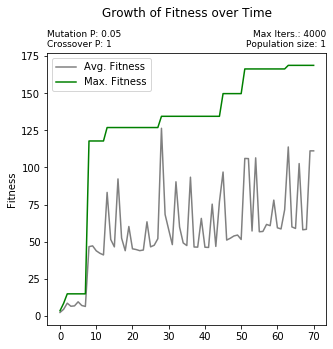

In [76]:
import matplotlib
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 6))

f, axs = plt.subplots(1, 1, sharex = True, sharey = False)
f.set_size_inches(5, 5)

axs.plot(fit_rise, c="gray", label="Avg. Fitness")
# axs[1].plot(l_g, c="red", label="Max. Lifespan")
# axs[2].plot(p_g, c="orange", label="Max. Peak")
# axs[3].plot(i_g, c="grey", label="Max. Peak")
axs.plot(fit_max_rise, c="green", label = "Max. Fitness")
axs.set_title("Growth of Fitness over Time\n\n")
axs.set_title("Max Iters.: "+str(In)+"\nPopulation size: "+str(len(new_pop.members)),loc="right",fontdict = {'fontsize': 9})
axs.set_title("Mutation P: "+str(Pm)+"\nCrossover P: "+str(Pr),loc="left",fontdict = {'fontsize': 9})

# axs[2].set_xlabel("Generations")
axs.set_ylabel("Fitness")
# axs[1].set_ylabel("Lifespan")
# axs[2].set_ylabel("Peak Population")
axs.legend()
plt.show()
